# Census - Total Population

#### This notebook contains code for gathering Census data tables and converting them to dataframes. 
#### Please use caution when altering this code.

In [14]:
import pandas as pd
from census import Census #<-- Python wrapper for census API
import requests
import os
import matplotlib.pyplot as plt
import matplotlib



# Census API Key
from config import api_key

# provide the api key and the year to establish a session
c = Census(api_key, year=2018)

# Set an option to allow up to 300 characters to print in each column
pd.set_option('max_colwidth', 300)

In [15]:
tables = c.acs5.tables()

# The tables variable contains a list of dicts, so we can convert directly to a dataframe
table_df = pd.DataFrame(tables)

##### The cell below gathering columns names from the Census Total Population table that only contain estimate and are int data types.
##### Those table names are added to a string variable and then pulled from the census data.
##### Dictionary key names are replaced withe more meaningful names.
##### Data is saved to a dataframe and exported as a csv file.

In [16]:
table_id = 'B01003'   

# Capture the variables URL from the table_df
url = table_df.loc[table_df['name']==table_id, 'variables'].values[0]

# Make the API call
response = requests.get(url).json()

# convert the response to a DataFrame
variables = pd.DataFrame(response['variables']).transpose()

print(f"Number of available variables: {len(variables)}")

table_info = variables[(variables['predicateType']=='int') & (variables['label'].str.contains("Estimate"))]   


table_columns = ""
for ind in table_info.index:       
    table_columns = table_columns + f"{ind},"
    
    
column_list = table_columns[:-1]
census_data = c.acs5.get(("NAME", column_list), 
                          {'for': 'county:*'})

for i in range(len(table_info)) : 
    for d in census_data:
        d[table_info.iloc[i, 0]] = d.pop(table_info.index[i]) 
    

census_B01003_TotalPop_df = pd.DataFrame(census_data)
census_B01003_TotalPop_df.to_csv("census_B01003_TotalPop.csv", encoding="utf-8", index=False )
census_B01003_TotalPop_df

Number of available variables: 4


,NAME,state,county,Estimate!!Total
0,"Washington County, Mississippi",28,151,47086.0
1,"Perry County, Mississippi",28,111,12028.0
2,"Choctaw County, Mississippi",28,019,8321.0
3,"Itawamba County, Mississippi",28,057,23480.0
4,"Carroll County, Mississippi",28,015,10129.0
...,...,...,...,...
3215,"Clayton County, Iowa",19,043,17672.0
3216,"Buena Vista County, Iowa",19,021,20260.0
3217,"Guthrie County, Iowa",19,077,10674.0
3218,"Humboldt County, Iowa",19,091,9566.0


### Census Total Population and New York Times Mask Data

In [19]:
census_B01003_TotalPop_df.dtypes

census_B01003_TotalPop_df['COUNTYFP'] = census_B01003_TotalPop_df['state'] + census_B01003_TotalPop_df['county']

census_TotalPop_sorted = census_B01003_TotalPop_df.sort_values(by=['COUNTYFP'])
census_TotalPop_sorted = census_TotalPop_sorted.reset_index(drop=True)

census_TotalPop_sorted['State Name'] = ''
census_TotalPop_sorted['County Name'] = ''


for index, row in census_TotalPop_sorted.iterrows():
    name_all = row['NAME']
    name_list = name_all.split(',')
    clean_state = name_list[1][1:]
    census_TotalPop_sorted.loc[index, 'State Name']= clean_state
    census_TotalPop_sorted.loc[index, 'County Name']= name_list[0]
    
census_TotalPop_sorted.head()

,NAME,state,county,Estimate!!Total,COUNTYFP,State Name,County Name
0,"Autauga County, Alabama",01,001,55200.0,01001,Alabama,Autauga County
1,"Baldwin County, Alabama",01,003,208107.0,01003,Alabama,Baldwin County
2,"Barbour County, Alabama",01,005,25782.0,01005,Alabama,Barbour County
3,"Bibb County, Alabama",01,007,22527.0,01007,Alabama,Bibb County
4,"Blount County, Alabama",01,009,57645.0,01009,Alabama,Blount County


In [20]:
infile = os.path.join("..", "NY_Times_Data", "mask-use-by-county.csv" )
nytimes_mask_data = pd.read_csv(infile)
# nytimes_mask_data.dtypes
nytimes_mask_data['COUNTYFP'] = nytimes_mask_data['COUNTYFP'].astype(str)
nytimes_mask_data['COUNTYFP'] = nytimes_mask_data['COUNTYFP'].str.zfill(5)
nytimes_mask_data

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,01001,0.053,0.074,0.134,0.295,0.444
1,01003,0.083,0.059,0.098,0.323,0.436
2,01005,0.067,0.121,0.120,0.201,0.491
3,01007,0.020,0.034,0.096,0.278,0.572
4,01009,0.053,0.114,0.180,0.194,0.459
...,...,...,...,...,...,...
3137,56037,0.061,0.295,0.230,0.146,0.268
3138,56039,0.095,0.157,0.160,0.247,0.340
3139,56041,0.098,0.278,0.154,0.207,0.264
3140,56043,0.204,0.155,0.069,0.285,0.287


In [21]:
nytimesmask_census = pd.merge(nytimes_mask_data, census_TotalPop_sorted, on="COUNTYFP", how="left")
nytimesmask_census

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,NAME,state,county,Estimate!!Total,State Name,County Name
0,01001,0.053,0.074,0.134,0.295,0.444,"Autauga County, Alabama",01,001,55200.0,Alabama,Autauga County
1,01003,0.083,0.059,0.098,0.323,0.436,"Baldwin County, Alabama",01,003,208107.0,Alabama,Baldwin County
2,01005,0.067,0.121,0.120,0.201,0.491,"Barbour County, Alabama",01,005,25782.0,Alabama,Barbour County
3,01007,0.020,0.034,0.096,0.278,0.572,"Bibb County, Alabama",01,007,22527.0,Alabama,Bibb County
4,01009,0.053,0.114,0.180,0.194,0.459,"Blount County, Alabama",01,009,57645.0,Alabama,Blount County
...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56037,0.061,0.295,0.230,0.146,0.268,"Sweetwater County, Wyoming",56,037,44117.0,Wyoming,Sweetwater County
3138,56039,0.095,0.157,0.160,0.247,0.340,"Teton County, Wyoming",56,039,23059.0,Wyoming,Teton County
3139,56041,0.098,0.278,0.154,0.207,0.264,"Uinta County, Wyoming",56,041,20609.0,Wyoming,Uinta County
3140,56043,0.204,0.155,0.069,0.285,0.287,"Washakie County, Wyoming",56,043,8129.0,Wyoming,Washakie County


In [38]:
nytimesmaskcensus_grouped = nytimesmask_census.groupby(['State Name', 'state'])
# nytimesmaskcensus_grouped.count()
nytimesmaskcensus_mean = round(nytimesmaskcensus_grouped.mean(), 3)
nytimesmaskcensus_sum = nytimesmaskcensus_grouped.sum()
nytimesmaskcensus_sum
nytimesmaskcensus_stats = nytimesmaskcensus_mean.drop(columns='Estimate!!Total')

nytimesmaskcensus_stats_pop = pd.DataFrame()
nytimesmaskcensus_stats_pop['TOTAL POP (ESTIMATE)'] = nytimesmaskcensus_sum['Estimate!!Total']
nytimesmaskcensus_stats_pop['NEVER - POP'] = round(nytimesmaskcensus_stats['NEVER'] * nytimesmaskcensus_stats_pop['TOTAL POP (ESTIMATE)'], 0) 
nytimesmaskcensus_stats_pop['RARELY - POP'] = round(nytimesmaskcensus_stats['RARELY'] * nytimesmaskcensus_stats_pop['TOTAL POP (ESTIMATE)'], 0)
nytimesmaskcensus_stats_pop['SOMETIMES - POP'] = round(nytimesmaskcensus_stats['SOMETIMES'] * nytimesmaskcensus_stats_pop['TOTAL POP (ESTIMATE)'], 0) 
nytimesmaskcensus_stats_pop['FREQUENTLY - POP'] = round(nytimesmaskcensus_stats['FREQUENTLY'] * nytimesmaskcensus_stats_pop['TOTAL POP (ESTIMATE)'], 0) 
nytimesmaskcensus_stats_pop['ALWAYS - POP'] = round(nytimesmaskcensus_stats['ALWAYS'] * nytimesmaskcensus_stats_pop['TOTAL POP (ESTIMATE)'], 0) 
nytimesmaskcensus_stats_pop = nytimesmaskcensus_stats_pop.reset_index()
nytimesmaskcensus_stats_pop.head()
nytimesmaskcensus_stats_pop.head()

census_TotalPop = nytimesmaskcensus_stats_pop

,State Name,state,TOTAL POP (ESTIMATE),NEVER - POP,RARELY - POP,SOMETIMES - POP,FREQUENTLY - POP,ALWAYS - POP
0,Alabama,01,4864680.0,398904.0,394039.0,715108.0,1045906.0,2310723.0
1,Alaska,02,738516.0,40618.0,46527.0,66466.0,245926.0,338979.0
2,Arizona,04,6946685.0,347334.0,368174.0,659935.0,1021163.0,4550079.0
3,Arkansas,05,2990671.0,272151.0,260188.0,412713.0,660938.0,1384681.0
4,California,06,39148760.0,1252760.0,1213612.0,2505521.0,6224653.0,27991363.0


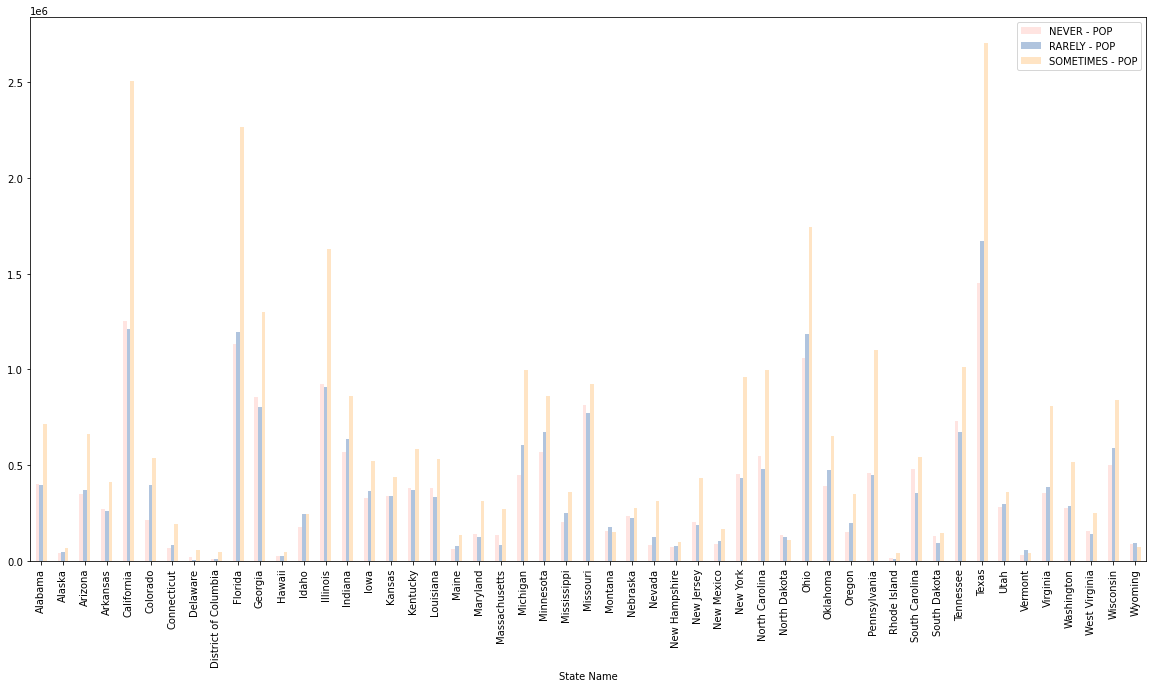

In [29]:
# colors = ['mistyrose', 'lightsteelblue','bisque', 'darkorange', 'seagreen', 'gold' ]

# nytimesmaskcensus_stats_pop.plot(kind='bar', y = ['NEVER - POP', 'RARELY - POP','SOMETIMES - POP' ], 
#                                  figsize=(20,10), color=colors)



#### Covid-19 Data

In [30]:
# Save config information.
url = "https://api.covidtracking.com/v1/states/current.json"

covid_json = requests.get(url).json()

In [31]:
states= []
fips = []
deaths= []
hospitalized = []
covid_positives = []
dates = []

indices = list( range(len(covid_json)))

for i in indices:
    states.append(covid_json[i]['state'])
    fips.append(covid_json[i]['fips'])
    dates.append(covid_json[i]['date'])
    deaths.append(covid_json[i]['death'])
    hospitalized.append(covid_json[i]['hospitalizedCumulative'])
    covid_positives.append(covid_json[i]['positive'])

In [33]:
AllStates_dict = {
    "States": states,
    "FIPS": fips,
    "Date": dates,
    "Covid Positive": covid_positives,
    "Cumaltive Hospitalized": hospitalized,
    "Deaths": deaths
}
AllStates_df = pd.DataFrame(AllStates_dict )
AllStates_df

,States,FIPS,Date,Covid Positive,Cumaltive Hospitalized,Deaths
0,AK,02,20200915,7313,NaN,44
1,AL,01,20200915,140160,15756.0,2387
2,AR,05,20200915,71357,4802.0,1010
3,AS,60,20200915,0,NaN,0
4,AZ,04,20200915,209209,21800.0,5344
5,CA,06,20200915,760013,NaN,14451
6,CO,08,20200915,61699,7240.0,1894
7,CT,09,20200915,55031,11357.0,4485
8,DC,11,20200915,14687,NaN,616
9,DE,10,20200915,19137,NaN,618


In [40]:
mask_covid_data = pd.merge(nytimesmaskcensus_stats_pop, AllStates_df, how="outer", left_on='state', right_on='FIPS')
mask_covid_data

,State Name,state,TOTAL POP (ESTIMATE),NEVER - POP,RARELY - POP,SOMETIMES - POP,FREQUENTLY - POP,ALWAYS - POP,States,FIPS,Date,Covid Positive,Cumaltive Hospitalized,Deaths
0,Alabama,01,4864680.0,398904.0,394039.0,715108.0,1045906.0,2310723.0,AL,01,20200915,140160,15756.0,2387
1,Alaska,02,738516.0,40618.0,46527.0,66466.0,245926.0,338979.0,AK,02,20200915,7313,NaN,44
2,Arizona,04,6946685.0,347334.0,368174.0,659935.0,1021163.0,4550079.0,AZ,04,20200915,209209,21800.0,5344
3,Arkansas,05,2990671.0,272151.0,260188.0,412713.0,660938.0,1384681.0,AR,05,20200915,71357,4802.0,1010
4,California,06,39148760.0,1252760.0,1213612.0,2505521.0,6224653.0,27991363.0,CA,06,20200915,760013,NaN,14451
5,Colorado,08,5531141.0,215714.0,398242.0,536521.0,1349598.0,3025534.0,CO,08,20200915,61699,7240.0,1894
6,Connecticut,09,3581504.0,64467.0,82375.0,193401.0,451270.0,2793573.0,CT,09,20200915,55031,11357.0,4485
7,Delaware,10,949495.0,18040.0,6646.0,57919.0,91152.0,776687.0,DE,10,20200915,19137,NaN,618
8,District of Columbia,11,684498.0,8214.0,8898.0,47230.0,112258.0,508582.0,DC,11,20200915,14687,NaN,616
9,Florida,12,20598139.0,1132898.0,1194692.0,2265795.0,3996039.0,12008715.0,FL,12,20200915,668846,42127.0,12946
